1. Read Image
2. Calibrate
3. Apply color and gradient thresholds
4. Perspective transform to get radius of curvature
6. Sliding window search for lanes
7. Convert to original perspective

### Imports

In [345]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# to read images named as name1, name2, ...
import glob
%matplotlib inline

# functions mini-library

# canny edge detection with auto calculated thresholds
def auto_threshold_canny(original_image, src_image):
    """ Compute the median of the single channel pixel intensities and
        use it to determine low and high thresholds for canny edge detection function.
        Source: https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
    """
    m = np.median(original_image)
    sigma=0.33
    # apply automatic Canny edge detection using the computed median
    low_threshold = int(max(0, (1.0 - sigma) * m))
    high_threshold = int(min(255, (1.0 + sigma) * m))
    return cv2.Canny(src_image, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    # Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# unwarp the corners of the chessboard image
def cornersUnwarp(img, nx, ny, mtx, dist, corners):
    # Pass in your image into this function
    # Write code to do the following steps
    img_size = (img.shape[1], img.shape[0])
    # extra space for including more of the image
    xe = (corners[1][0][0] - corners[0][0][0])/2
    ye = (corners[nx][0][1] - corners[0][0][1])/2
    # source points
    src = np.float32((corners[0][0] - [xe, ye],
        corners[nx-1][0] + [xe, -ye],
        corners[(nx*ny)-1][0] + [xe, ye],
        corners[nx*(ny-1)][0] - [xe, -ye]))
    tl, tr, br, bl = src
    # destination points
    dst = np.float32([[0, 0],
        [img_size[0] - 1, 0],
        [img_size[0] - 1, img_size[1] - 1],
        [0, img_size[1] - 1]])
    # get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

# calibrate the camera and return the camera marix to be used later
def camCalibrate(img_name_list):
    for name in img_name_list:
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert to grayscale
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)    # Find the chessboard corners
        # If found, store imagepoint and object point data and draw corners
        if ret == True:
            objPoints.append(np.copy(objp))
            imgPoints.append(corners)
            #images.append(img)
    # get calibration parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1],
                                                           None, None, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
    return mtx, dist
    
# get calibrated image
def getCaliberatedImage(image, mtx, dist):
    undist = np.zeros_like(image)
    undist[:,:,0] = cv2.undistort(image[:,:,0], mtx, dist, None, mtx)
    undist[:,:,1] = cv2.undistort(image[:,:,1], mtx, dist, None, mtx)
    undist[:,:,2] = cv2.undistort(image[:,:,2], mtx, dist, None, mtx)
    return undist

# subtract median from image
def getMedianLessImage(img):
    #hsv = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2HSV)
    t_img = np.zeros_like(img)
    t1 = img[:,:,0] - np.median(img[:,:, 0])*1.3
    t2 = img[:,:,1] - np.median(img[:,:, 1])*1.3
    t3 = img[:,:,2] - np.median(img[:,:, 2])*1.3
    t1[t1<0] = 0
    t2[t2<0] = 0
    t3[t3<0] = 0
    t_img[:,:,0], t_img[:,:,1], t_img[:,:,2] = t1, t2, t3
    return t_img

# get mask for the image which would be used to get the lane lines
def getColorMaskedImage(rgbimg, median_less = True):
    # get mask structures as per input image dimensions
    masked_img = np.zeros_like(rgbimg[:,:,0])
    t_img = getMedianLessImage(rgbimg)
    base_thresh = 100
    d_factor = 10
    generic_mean = 70
    if not median_less:
        base_thresh = 220
        d_factor = 15
        generic_mean = 80
    # Prepare thresholds
    rm = base_thresh - (generic_mean - np.median(rgbimg[:,:, 0])) / d_factor
    gm = base_thresh - (generic_mean - np.median(rgbimg[:,:, 1])) / d_factor
    bm = base_thresh - (generic_mean - np.median(rgbimg[:,:, 2])) / d_factor
    masked_img[(t_img[:,:,0]>=rm) | (t_img[:,:,1]>=gm) | (t_img[:,:,2]>=bm)] = 1
    return masked_img

# get gradient in x or y direction of magnitude of te gradient, axis can be 'x', 'y' or 'm'
def getGradient(gray, axis='x', sobel_kernel=3):
    grad = None
    if axis == 'x':
        grad = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif axis == 'y':
        grad = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        gradx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        grady = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        grad = np.sqrt((gradx ** 2) + (grady ** 2))
        
    grad = np.uint8(255*grad/np.max(grad))
    return grad

# get threshold in specified direction range
def dirThreshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # gradient in x and y separately
    abs_sobelx = getGradient(gray, 'x', 3)
    abs_sobely = getGradient(gray, 'y', 3)
    # calculate the direction of the gradient 
    sobel_thresh = np.arctan2(abs_sobely, abs_sobelx)
    # binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_sobelx)
    binary_output[(sobel_thresh >= thresh[0]) & (sobel_thresh <= thresh[1])] = 1
    return binary_output


def prepareImageMask(bgrimg):
    rgbimg = cv2.cvtColor(bgrimg, cv2.COLOR_BGR2RGB)
    hsvimg = cv2.cvtColor(bgrimg, cv2.COLOR_BGR2HSV)
    # get image after subtracting color channel medians of that image
    mlimg = getMedianLessImage(bgrimg)
    gray = cv2.cvtColor(mlimg, cv2.COLOR_BGR2GRAY)
    # get gradient in x direction
    d_mask = getGradient(gray, 'x', 3)
    # prepare a mask and return
    bin_mask = np.zeros_like(d_mask)
    bin_mask[(d_mask > 10) | (hsvimg[:,:,2] > 180)] = 1
    return bin_mask

# find points for use in perspective transform from the image
'''
    Needs to be corrected
'''
def getSourceDestPoints(image_2d_mask):
    # two slots in image
    w = image_2d_mask.shape[1]
    h = image_2d_mask.shape[0]
    top1 = h*7//9
    top2 = h*5//9
    
    histogram = np.sum(image_2d_mask[top1:,:], axis=0)
    left_hist = histogram[:len(histogram)//2]
    right_hist = histogram[len(histogram)//2:]
    sl = np.argmax(left_hist)
    sr = np.argmax(right_hist) + len(histogram)//2

    histogram = np.sum(cmimg[top2:top1,:], axis=0)
    left_hist = histogram[:len(histogram)//2]
    right_hist = histogram[len(histogram)//2:]
    el = np.argmax(left_hist)
    er = np.argmax(right_hist) + len(histogram)//2
    
    # hardcoded part
    src = np.float32(([(img_size[0]/2)-40, img_size[1]*0.62],
    [(img_size[0]/2)+80, img_size[1]*0.62],
    [img_size[0], img_size[1]],
    [0, img_size[1]]))

    dst = np.float32([[0, 0],
        [img_size[0], 0],
        [img_size[0], img_size[1]],
        [0, img_size[1]]])

    return src, dst

# find single base point for sliding window search
def find_base_top(histogram, group_size = 10):
    new_histogram = []
    histogram = list(histogram)
    while int(len(histogram)%group_size) != 0:
        histogram.append(0)
    for i in range(0, len(histogram), group_size):
        new_histogram.append(sum(histogram[i:i+group_size]))
    ct = np.argmax(new_histogram)
    base, top = 0, 0
    # loop backwards to get the base by finding the local minima
    # loop forward to get the top by finding the local minima
    for sv, lv, inc in [(ct, 0, -1), (ct, len(new_histogram), 1)]:
        dif = 0
        for i in range(sv, lv, inc):
            cdif = new_histogram[ct] - new_histogram[i]
            if cdif >= dif:
                dif = cdif
            else:
                if inc < 0:
                    base = i
                else:
                    top = i
                break
    base = int(round(base*group_size + group_size*0.65))  # This could be improved to increase accuracy
    top = int(round(top*group_size + group_size*0.45))
    return base, top

# find initial base point for sliding window search
def find_initial_base_top(histogram, group_size = 10):
    new_histogram = list(histogram)
    left_hist = new_histogram[:len(new_histogram)//2]
    right_hist = new_histogram[len(new_histogram)//2:]
    n = len(left_hist)
    bl, tl = find_base_top(left_hist, group_size)
    br, tr = find_base_top(right_hist, group_size)
    br, tr = br+n, tr+n
    return (bl, tl), (br, tr)

# perform a perspective transform
def transformPerspective(image, src_points, dst_points):
    pass

# Find the position of peaks from the image slice of size image height x slf (0.15 <= slf <= 0.85)
def getHistogramPeakPositions(warped_image, min_y, max_y):
    histogram = np.sum(warped[min_y:max_y,:], axis=0)
    left_hist = histogram[:len(histogram)//2]
    right_hist = histogram[len(histogram)//2:]
    sl = np.argmax(left_hist)
    sr = np.argmax(right_hist) + len(histogram)//2
    return sl, sr

# get next window for scanning the line
def getNextWindow(image, top_h, bottom_h, current_x):
    pass

# scan for line
def getLinex(image, window, last_x):
    pass

# scan and fit a curve on the scanned line in the image
def fitCurve(image, points, line_color, line_thickness, area_color):
    pass

### Calibrate the Camera

In [260]:
# prepare object points
# number of inside corners in x and y
nx, ny = 9, 6
# Store Object points and image points from all the images
objPoints = []  # 3D points in real world space
imgPoints = []  # 3D points in image place

# Prepare object points like (0,0,0), (1,0,0), (2,0,0)...(8,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # a list of x, y coordinates

# Make a list of calibration images
image_names = glob.glob('./camera_cal/calibration*.jpg')
rows = len(image_names)

cam_mtx = None
cam_dist = None

# read all the images and prepare camera matrix
cam_mtx, cam_dist = camCalibrate(image_names)

#### Test Image Calibration

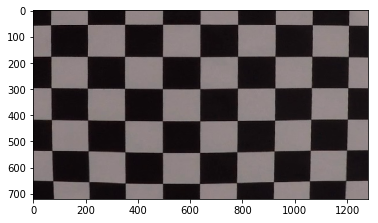

In [13]:
# test camera matrix on a chessboard image
img = cv2.imread(image_names[8])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert to grayscale
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)    # Find the chessboard corners
undist = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
warped_image = cornersUnwarp(undist, nx, ny, cam_mtx, cam_dist, corners)
plt.imshow(warped_image)
plt.show()

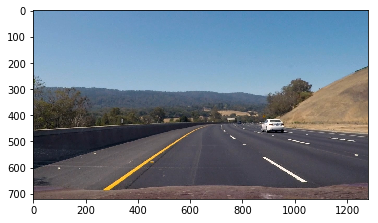

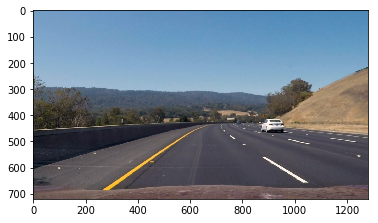

In [297]:
t_img = cv2.imread("./test_images/road26.jpg")
img = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img = getCaliberatedImage(img, cam_mtx, cam_dist)
plt.imshow(img)
plt.show()

### Apply Thresholds to Image

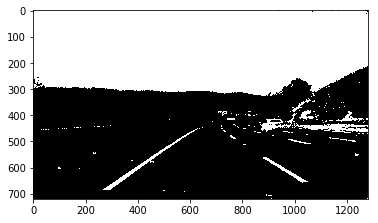

In [298]:
# Apply color thresholds
cmimg = prepareImageMask(t_img)
plt.imshow(cmimg, cmap="gray")
plt.show()

### Transform the Perspective

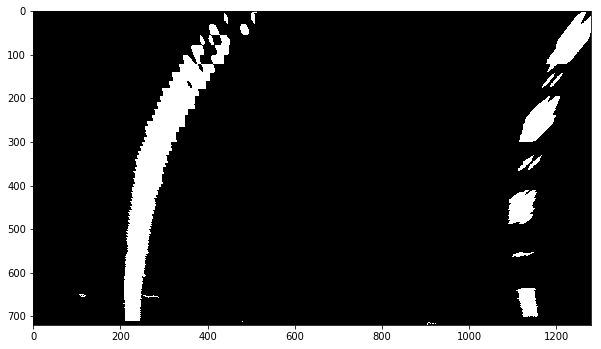

In [342]:
img_size = (cmimg.shape[1], cmimg.shape[0])
src, dst = getSourceDestPoints(cmimg)

M = cv2.getPerspectiveTransform(src, dst)
rM = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(cmimg, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize=(10,10))
plt.imshow(warped, cmap="gray")
plt.show()

unwarped = cv2.warpPerspective(warped, rM, img_size, flags=cv2.INTER_LINEAR)
#plt.figure(figsize=(16,10))
#plt.imshow(unwarped, cmap="gray")
#plt.show()

### Sliding window search 

[]
[]
[]
[]
[]
[]
[]
[]
[14350 14449 14545 14641 14737 14833 14927 15020 15113 15204 15295 15296
 15387 15388 15478 15567 15655 15743 15845]
[14314 14315 14316 ... 20753 20754 20755]
[14281 14282 14283 ... 30637 30638 30639]
[14269 14270 14271 ... 31400 31401 31402]
[18699 18700 18701 ... 31371 31372 31373]
[30674 30675 30740 30741 30806 30807 30872 30873 30938 31004 31332 31333
 31334 31335 31336 31337]
[]
[]
[]
[]
[]
[]


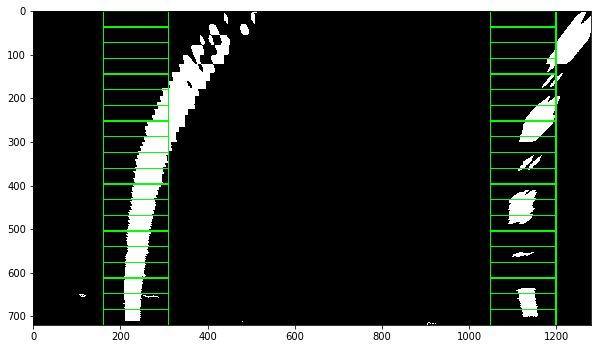

In [361]:
win_n = 20    # number of vertical segments
win_h = warped.shape[0] // win_n    # height of each segment
left_points = []   # [(x1, y1), (x2, y2), ...] points for left lane line
right_points = []  # points depicting right lane line

# points found for last window

out_img = np.dstack((warped, warped, warped))*255

clx, crx = getHistogramPeakPositions(warped, warped_image.shape[0]//2, warped.shape[0]+1)
#print(lx, rx)
non_zero = warped.nonzero()
non_zero_x = non_zero[0]
non_zero_y = non_zero[1]
win_w = 75
exp_points = 30

for cwin_n in range(0, win_n):
    win_min_y = warped.shape[0]*(win_n - cwin_n - 1)//win_n
    win_max_y = win_min_y + win_h
    if win_min_y < 0:
        win_min_y = 0
    nlx, nrx = 0, 0
    # rectangle coordinates
    left_x_mn = clx - win_w
    left_x_mx = clx + win_w
    right_x_mn = crx - win_w
    right_x_mx = crx + win_w
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (left_x_mn, win_min_y), (left_x_mx, win_max_y), (0,255,0), 2)
    cv2.rectangle(out_img, (right_x_mn, win_min_y), (right_x_mx, win_max_y), (0,255,0), 2)
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = 
    print(good_left_inds)
    good_right_inds = 

plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.show()